# Summary

In [1]:
%load_ext autoreload

import os
import numpy as np
import scipy.io as sio

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import zscore

import flygenvectors.plotting as plotting
import flygenvectors.utils as utils
import flygenvectors.ssmutils as ssmutils
import flygenvectors.data as dataUtils
from flygenvectors.dlc import DLCLabels

In [2]:
plot_dark = False

sns.set_context('talk')
if plot_dark:
    plt.style.use('dark_background')
#     cmap_rasters = 'inferno'
    cmap_rasters = 'afmhot'
else:
    sns.set_style('white')
    cmap_rasters = 'Greys'

# 1. Load and preprocess data

In [3]:
# options
# expt_id = '190424_f3'  # (run+feed)
# expt_id = '180824_f3r1'
# expt_id = '2019_06_26_fly2'
# expt_id = '2019_06_28_fly2'
# expt_id = '2019_06_30_fly1'
expt_id = '2019_07_01_fly2'

# preprocessing directives
preprocess_list = {
    'interpolate_labels': {'thresh': 0.8, 'window': 3}, # "bad" labels replaced with avg of neighboring "good" labels
    # 'standardize': {}, # zscore labels
    'unitize': {}, # scale labels in [0, 1]
    'median_filter': {'window_size': 5},
    'remove_bad_runs': {'l_thresh': 0.8, 'min_length': 10} # remove runs where at least one label is "bad"
}
do_fit_differences = False  # fit label differences rather than original labels

do_single_label_interp = True  
do_standardize = False  # zscore labels
do_unitize = True  # put labels in [0, 1]
do_median_filter = True
do_remove_bad_runs = True  # remove runs where at least one label is "bad"


dlc_obj = DLCLabels(expt_id)
dlc_obj.load_from_csv()
dlc_obj.preprocess(preprocess_list)

# preprocess labels
if do_single_label_interp:
    dlc_obj.interpolate_single_bad_labels(thresh=0.8)
if do_standardize:
    dlc_obj.standardize(by_label=True)
if do_unitize:
    dlc_obj.unitize()
if do_median_filter:
    dlc_obj.filter('median')
    
if do_remove_bad_runs:
    # get long runs of low likelihood to remove
    skip_idxs_list = dlc_obj.extract_runs_by_likelihood(
        l_thresh=0.8, min_length=10, max_length=np.inf, 
        comparison='<=', dims='any', return_vals=True)
    skip_idxs = np.full(shape=(dlc_obj.labels['l'].shape[0], 1), fill_value=False)
    for si in skip_idxs_list:
        skip_idxs[si] = True
    print('removing %i low-likelihood time points' % np.sum(skip_idxs * 1.0))
else:
    skip_idxs = None
dlc_obj.extract_runs_by_likelihood(
    l_thresh=0.0, min_length=100, max_length=500, skip_idxs=ret['skip_idxs'])

# split labels into train/test/val
dlc_obj.split_labels(
    dtypes=['train', 'test', 'val'], dtype_lens=[5, 0, 1], diff=do_fit_differences)

# define model dir based on preprocessing
model_dir = 'dlc-arhmm'
if do_fit_differences:
    model_dir += '-diff'
if not do_remove_bad_runs:
    model_dir += '-alldata'
print('\nsaving models in the following directory: "%s"' % model_dir)

loading labels from /media/mattw/data/schaffer/2019_07_01_fly2/2019_07_01_fly2DeepCut_resnet50_RunningJul3shuffle1_1030000.csv...done
total time points: 192980
linearly interpolating single bad labels...done
linearly interpolated 7687 labels
unitizing labels...done
applying median filter to labels...done
extracting runs of labels <= likelihood=0.80...done
extracted 569 runs for a total of 14707 time points
removing 14707 low-likelihood time points
extracting runs of labels >= likelihood=0.00...done
extracted 389 runs for a total of 169647 time points
splitting labels into ['train', 'test', 'val']...done
	train: 141640 time points in 325 trials
	test: 0 time points in 0 trials
	val: 28007 time points in 64 trials

saving models in the following directory: "dlc-arhmm"


### check outliers

In [ ]:
# plot dlc labels/likelihoods over time
slc = (1200, 1400)
plot_diffs = False
frac = 20 

plt.figure(figsize=(12, 10))

plt.subplot(311)
plt.plot(np.arange(slc[0], slc[1]), dlc_obj.labels['l'][slice(*slc), :])
plt.title('likelihoods')

plt.subplot(312)
coord = 'x'
behavior = frac * dlc_obj.labels[coord] / np.max(np.abs(dlc_obj.labels[coord])) + \
    np.arange(dlc_obj.labels[coord].shape[1])
if plot_diffs:
    behavior = np.concatenate(
        [np.zeros(shape=(1, behavior.shape[1])), np.diff(behavior, axis=0)])
plt.plot(np.arange(slc[0], slc[1]), behavior[slice(*slc), :])
plt.title('%s coords' % coord)

plt.subplot(313)
coord = 'y'
behavior = frac * dlc_obj.labels[coord] / np.max(np.abs(dlc_obj.labels[coord])) + \
    np.arange(dlc_obj.labels[coord].shape[1])
if plot_diffs:
    behavior = np.concatenate(
        [np.zeros(shape=(1, behavior.shape[1])), np.diff(behavior, axis=0)])
plt.plot(np.arange(slc[0], slc[1]), behavior[slice(*slc), :])
plt.title('%s coords' % coord)

plt.xlabel('Time (bins)')
plt.tight_layout()
plt.show()

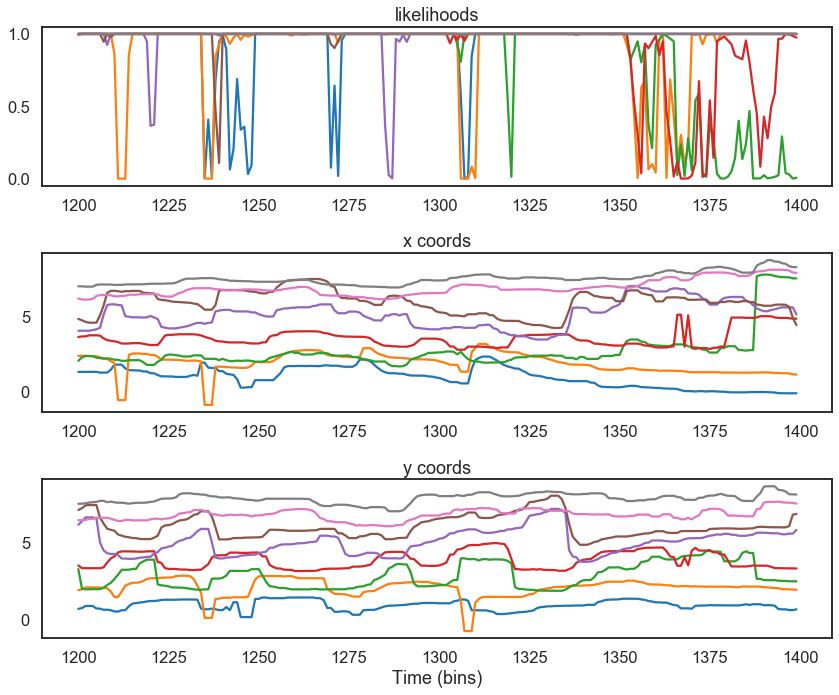

In [94]:
# plot dlc labels/likelihoods over time
slc = (1200, 1400)
plot_diffs = False
frac = 20 

plt.figure(figsize=(12, 10))

plt.subplot(311)
plt.plot(np.arange(slc[0], slc[1]), dlc_obj.labels['l'][slice(*slc), :])
plt.title('likelihoods')

plt.subplot(312)
coord = 'x'
behavior = frac * dlc_obj.labels[coord] / np.max(np.abs(dlc_obj.labels[coord])) + \
    np.arange(dlc_obj.labels[coord].shape[1])
if plot_diffs:
    behavior = np.concatenate(
        [np.zeros(shape=(1, behavior.shape[1])), np.diff(behavior, axis=0)])
plt.plot(np.arange(slc[0], slc[1]), behavior[slice(*slc), :])
plt.title('%s coords' % coord)

plt.subplot(313)
coord = 'y'
behavior = frac * dlc_obj.labels[coord] / np.max(np.abs(dlc_obj.labels[coord])) + \
    np.arange(dlc_obj.labels[coord].shape[1])
if plot_diffs:
    behavior = np.concatenate(
        [np.zeros(shape=(1, behavior.shape[1])), np.diff(behavior, axis=0)])
plt.plot(np.arange(slc[0], slc[1]), behavior[slice(*slc), :])
plt.title('%s coords' % coord)

plt.xlabel('Time (bins)')
plt.tight_layout()
plt.show()

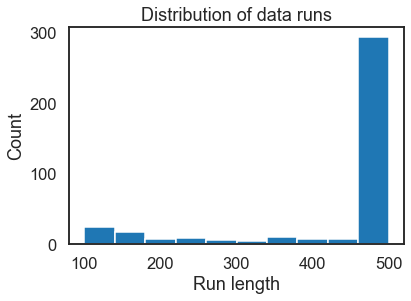

In [5]:
# plot distribution of run lengths
import matplotlib.pyplot as plt
plt.figure()
plt.hist([len(i) for i in dlc_obj.idxs_valid])
plt.xlabel('Run length')
plt.ylabel('Count')
plt.title('Distribution of data runs')
plt.show()

# 2. Fit dynamics

### ARHMM - how many discrete states?

In [60]:
# %autoreload 2
# import flygenvectors.ssmutils as ssmutils
n_states = [2, 3, 4, 5, 6, 9, 12, 15, 18]
# n_states = []
D = dlc_obj.labels_dict['train'][0].shape[1]
sticky_lags = 3
model_kwargs = {
#     'hmm': {
#         'transitions': 'standard', 
#         'observations': 'gaussian'},
#     'arhmm-s2-%i' % sticky_lags: {
#         'transitions': 'sticky', 
#         'transition_kwargs': {'kappa': 1e2},
#         'observations': 'ar',
#         'observation_kwargs': {'lags': sticky_lags}},
#     'arhmm-s4-%i' % sticky_lags: {
#         'transitions': 'sticky', 
#         'transition_kwargs': {'kappa': 1e4},
#         'observations': 'ar',
#         'observation_kwargs': {'lags': sticky_lags}},
#     'arhmm-s6-%i' % sticky_lags: {
#         'transitions': 'sticky', 
#         'transition_kwargs': {'kappa': 1e6},
#         'observations': 'ar',
#         'observation_kwargs': {'lags': sticky_lags}},
#     'arhmm-s8-%i' % sticky_lags: {
#         'transitions': 'sticky', 
#         'transition_kwargs': {'kappa': 1e8},
#         'observations': 'ar',
#         'observation_kwargs': {'lags': sticky_lags}},
    'arhmm-1': {
        'transitions': 'standard', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 1}},
    'arhmm-2': {
        'transitions': 'standard', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 2}},
    'arhmm-3': {
        'transitions': 'standard', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 3}},
    'arhmm-5': {
        'transitions': 'standard', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 5}},
#     'arhmm-7': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 7}},
}

fit_kwargs = {
    'save': True,
    'load_if_exists': True,
    'expt_id': expt_id,
    'model_dir': model_dir,
    'save_dir': None}

all_results = {}
# iterate over model types
for model_name, kwargs in model_kwargs.items():
#     if model_name in all_results and len(all_results[model_name] == n_states):
#         continue
    model_results = {}
    # iterate over discrete states
    for K in n_states:
        print('Fitting %s with %i states' % (model_name, K))
        model_results[K] = ssmutils.fit_model(
            n_states=K, data_dim=D, input_dim=0, model_kwargs=kwargs,
            data_tr=dlc_obj.labels_dict['train'], 
            data_val=dlc_obj.labels_dict['val'],
            data_test=dlc_obj.labels_dict['test'],
            fit_kwargs=fit_kwargs)
    all_results[model_name] = model_results

Fitting arhmm-1 with 2 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=1_K=02.pkl
Fitting arhmm-1 with 3 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=1_K=03.pkl
Fitting arhmm-1 with 4 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=1_K=04.pkl
Fitting arhmm-1 with 5 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=1_K=05.pkl
Fitting arhmm-1 with 6 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=1_K=06.pkl
Fitting arhmm-1 with 9 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=1_K=09.pkl
Fitting arhmm-1 with 12 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=1_K=12.pkl
Fitting arhmm-1 with 15 states
loading m

saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=2_K=02.pkl
Fitting arhmm-2 with 3 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=2_K=03.pkl
Fitting arhmm-2 with 4 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=2_K=04.pkl
Fitting arhmm-2 with 5 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=2_K=05.pkl
Fitting arhmm-2 with 6 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=2_K=06.pkl
Fitting arhmm-2 with 9 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=2_K=09.pkl
Fitting arhmm-2 with 12 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=2_K=12.pkl
Fitting arhmm-2 with 15 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=2_K=15.pkl
Fitting arhmm-2 with 18 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=2_K=18.pkl
Fitting arhmm-3 with 2 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=3_K=02.pkl
Fitting arhmm-3 with 3 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=3_K=03.pkl
Fitting arhmm-3 with 4 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=3_K=04.pkl
Fitting arhmm-3 with 5 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=3_K=05.pkl
Fitting arhmm-3 with 6 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=3_K=06.pkl
Fitting arhmm-3 with 9 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=3_K=09.pkl
Fitting arhmm-3 with 12 states
loading model from /home/mattw/results/fly/

In [91]:
(155+50)*5

1025

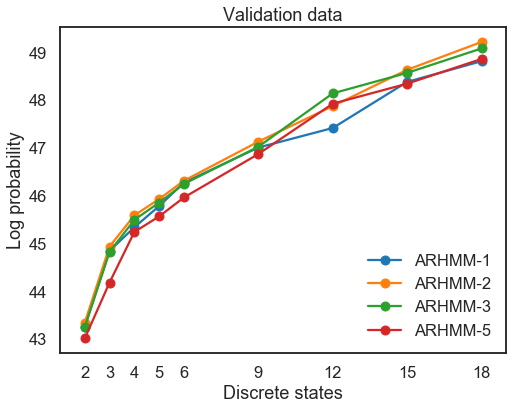

In [61]:
fig = plotting.plot_validation_likelihoods(
    all_results=all_results, 
    T_val=np.sum([d.shape[0] for d in dlc_obj.labels_dict['val']]))
plt.legend(loc='lower right', frameon=False)

# 3. Probe learned dynamics

In [87]:
# choose model
K = 9
n_lags = 5
model_name = str('arhmm-%i' % n_lags)
dtype = 'train'
arhmm = all_results[model_name][K]['model']
# get most likely states
states_all = [arhmm.most_likely_states(d) for d in dlc_obj.labels_dict[dtype]]

In [ ]:
# state usage plot

In [79]:
print(1.25/3)
print(1.50/4)
print(1.75/5)

0.4166666666666667
0.375
0.35


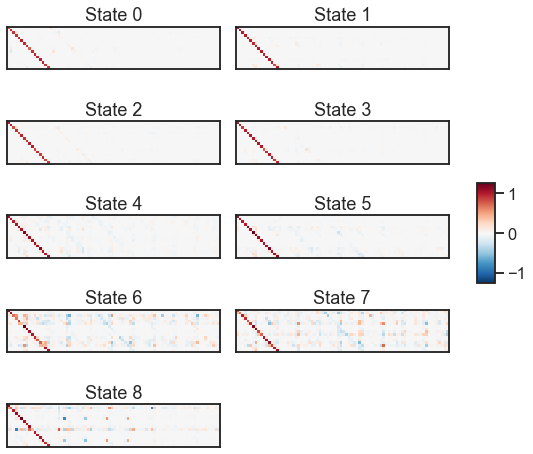

In [89]:
%autoreload
fig = plotting.plot_dynamics_matrices(arhmm, deridge=False)

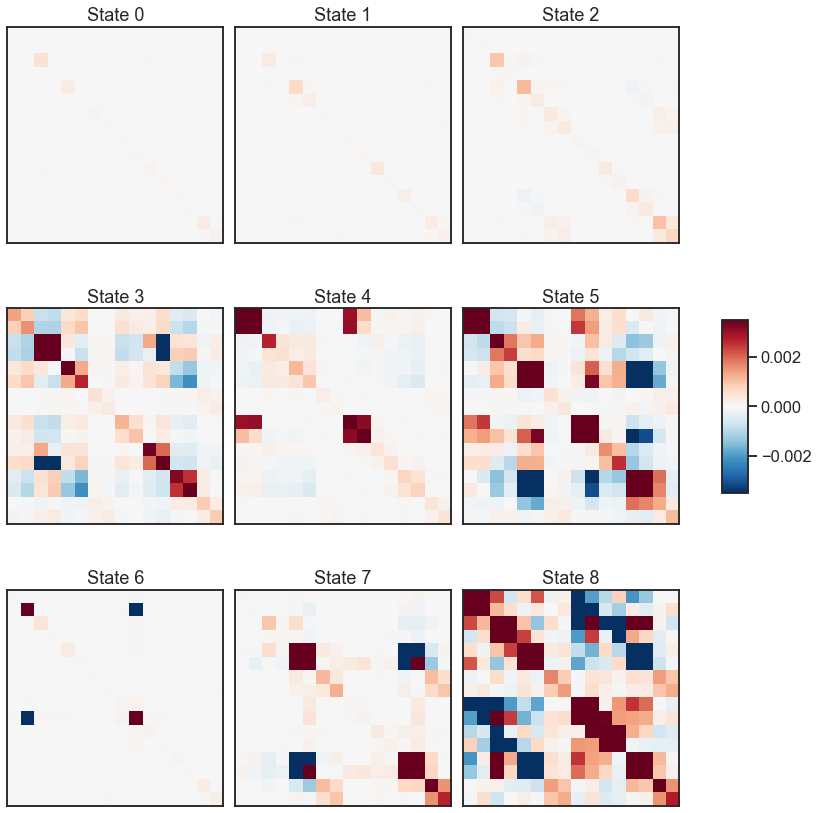

In [44]:
fig = plotting.plot_covariance_matrices(arhmm)

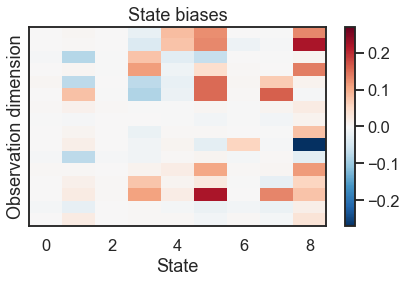

In [45]:
fig = plotting.plot_biases(arhmm)

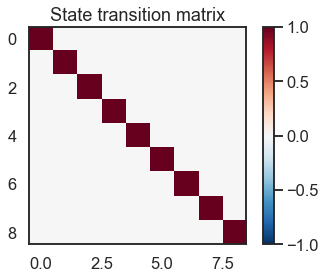

In [46]:
fig = plotting.plot_state_transition_matrix(arhmm)

### find multiple snippets of validation data for each state

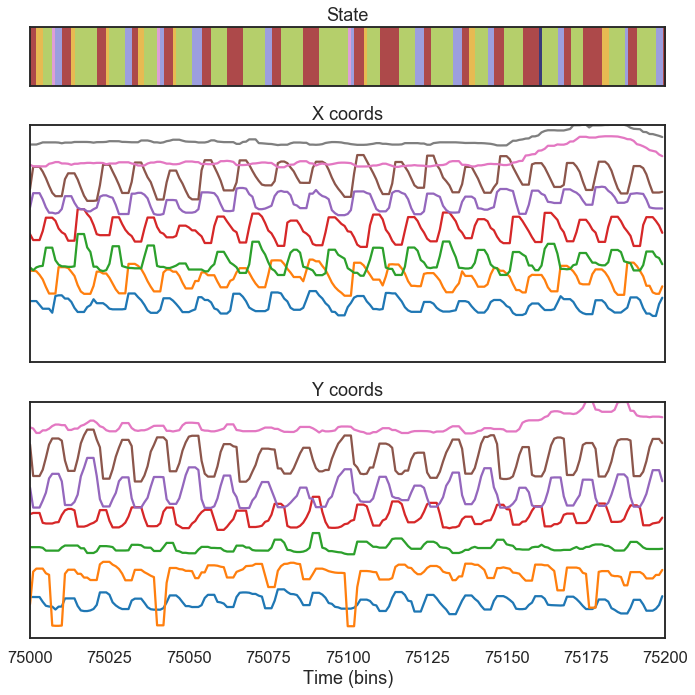

In [57]:
# infer all states and plot dlc lablels
states_ = arhmm.most_likely_states(dlc_obj.get_label_array())
slc = (75000, 75200)
fig = plotting.plot_dlc_arhmm_states(
    dlc_labels=dlc_obj.labels, state_probs=None, states=states_, slc=slc)

In [14]:
# import pickle
# data = {
#     'states_train': [arhmm.most_likely_states(d) for d in dlc_obj.labels_dict['train']],
#     'states_val': [arhmm.most_likely_states(d) for d in dlc_obj.labels_dict['val']],
#     'idxs_train': dlc_obj.idxs_dict['train'],
#     'idxs_val': dlc_obj.idxs_dict['val']}
# with open('/home/mattw/results/fly/arhmm_dlc_states.pkl', 'wb') as f:
#     pickle.dump(data, f)

In [58]:
# collect all state snippets
indx_snippets = ssmutils.extract_state_runs(
    states_all, dlc_obj.idxs_dict[dtype], min_length=2)

# get dlc labels
dlc_snippets = [{'x': [], 'y': []} for _ in range(K)]
state_lengths = [[] for _ in range(K)]
for k, k_indxs in enumerate(indx_snippets):
    for k_indx in k_indxs:
        state_lengths[k].append(len(k_indx))
        for coord in ['x', 'y']:
            dlc_snippets[k][coord].append(dlc_obj.labels[coord][k_indx])        
state_lengths = [np.array(state_lengths[k]) for k in range(K)]

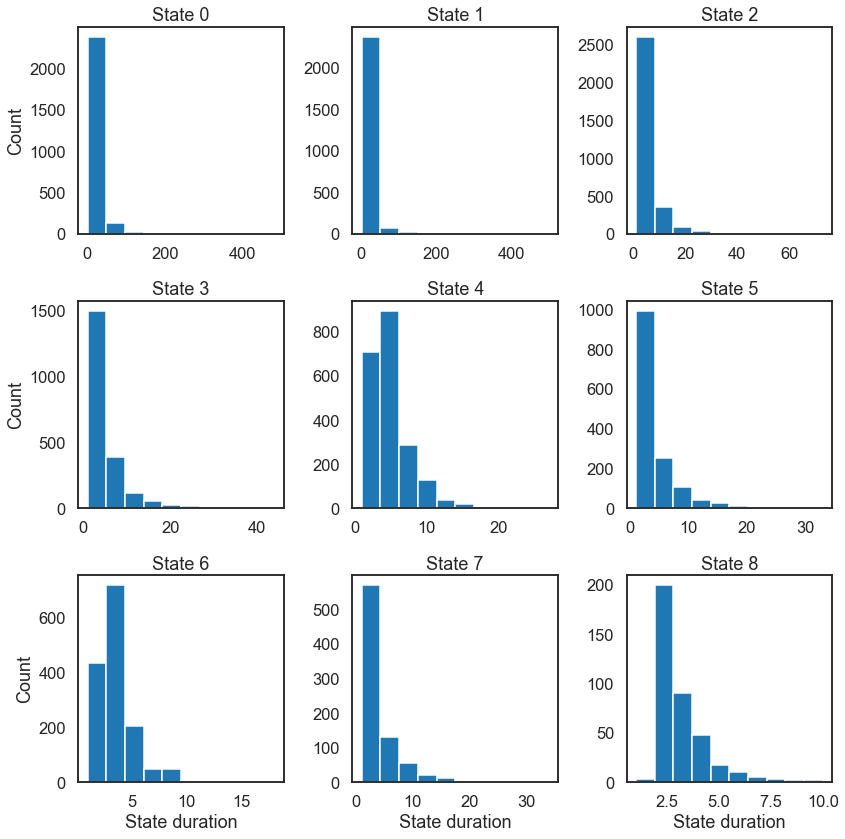

In [59]:
# plot distribution of state durations
n_cols = 3
n_rows = np.ceil(K / n_cols)

fig = plt.figure(figsize=(4 * n_cols, 4 * n_rows))

for i, slens in enumerate(state_lengths):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(slens) #, range=(0, 100))
    plt.title(str('State %i' % i))
    if plt.gca().is_first_col():
        plt.ylabel('Count')
    if plt.gca().is_last_row():
        plt.xlabel('State duration')
plt.tight_layout()
plt.show()

### check for state consistency across lags

In [18]:
# K = 12
# dtype = 'train'
# lags = [1, 2, 3, 5]
# states_ = {l:None for l in lags}

# for lag in lags:
#     if lag == 1:
#         model_name = 'arhmm'
#     else:
#         model_name = str('arhmm-%i' % lag)
#     arhmm = all_results[model_name][K]['model']
#     states_[lag] = arhmm.most_likely_states(dlc_array)

In [19]:
# slc = (75000, 75200)

# fig, axes = plt.subplots(
#     len(lags), 1, figsize=(10, 1.5 * len(lags)),
#     gridspec_kw={'height_ratios': [1 / len(lags)] * len(lags)})

# for i, l in enumerate(lags):
#     axes[i].imshow(states_[l][None, slice(*slc)], aspect='auto', cmap='tab20b')
#     axes[i].set_xticks([])
#     axes[i].set_yticks([])
#     axes[i].set_ylabel('%i lags' % l)
# plt.tight_layout()
# plt.show()

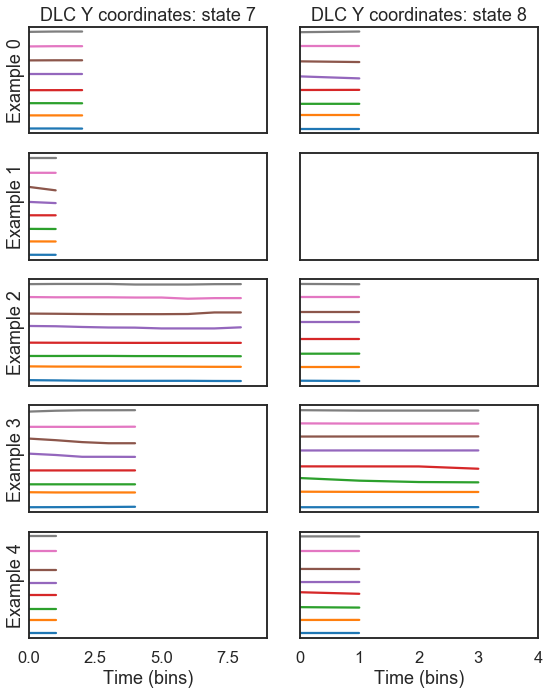

In [50]:
# %autoreload 2
fig = plotting.make_syllable_plots(
    dlc_snippets, max_snippets=5, max_t=100, coord='y', states_to_plot=[7, 8])

### play with smoothing

In [99]:
# infer all states and plot dlc lablels
labels = dlc_obj.get_label_array()
ps = dlc_obj.labels['l']
n_labels = int(labels.shape[1] / 2)
# states_ = arhmm.most_likely_states(labels)

In [ ]:
def plot_dlc(xs, ys, ps, slc, m=50):
    fig = plt.figure(figsize=(12, 10))
    plt.subplot(311)
    plt.plot(np.arange(slc[0], slc[1]), ps[slice(*slc), :])
    plt.title('likelihoods')
    plt.subplot(312)
    behavior = m * xs / np.max(np.abs(xs)) + np.arange(xs.shape[1])
    plt.plot(np.arange(slc[0], slc[1]), behavior[slice(*slc), :])
    plt.title('x coords')
    plt.subplot(313)
    behavior = m * ys / np.max(np.abs(ys)) + np.arange(ys.shape[1])
    plt.plot(np.arange(slc[0], slc[1]), behavior[slice(*slc), :])
    plt.title('y coords')
    plt.xlabel('Time (bins)')
    plt.tight_layout()
    plt.show()
    return fig

In [ ]:
# plot dlc labels/likelihoods over time
slc = (indx_snippets[3][0][0], indx_snippets[3][0][-1])
fig = plot_dlc(dlc_obj.labels['x'], dlc_obj.labels['y'], dlc_obj.labels['l'], slc)

In [ ]:
# import statsmodels.api as sm

# p_thresh = 0.9
# # labels_new = np.copy(labels)
# n_labels = int(labels.shape[1] / 2)
# # for nl in range(n_labels):
# nl = 1
# # fit to x
# x = np.copy(labels[:, nl])
# x[ps[:, nl]<p_thresh] = np.nan  # treat low-probability data points as missing data

# # fit to y
# # y = labels[:, n_labels+nl]

# sarimax = sm.tsa.statespace.SARIMAX(
#     x, order=(3, 0, 1), seasonal_order=(0, 0, 0, 0), simple_differencing=True)
# mle = sarimax.fit(disp=True)

In [ ]:
# n_forecast = 0
# predict = mle.get_prediction() #end=mle.nobs + n_forecast - 1)
# mean = predict.predicted_mean
# mean2 = np.concatenate([mean[1:], [0]])
# ci = predict.conf_int(alpha=0.05)

In [105]:
from scipy import signal
n_labels = int(labels.shape[1] / 2)
nl = 1
windowlength = 5
x = np.copy(labels[:, nl])
y = np.copy(labels[:, n_labels+nl])

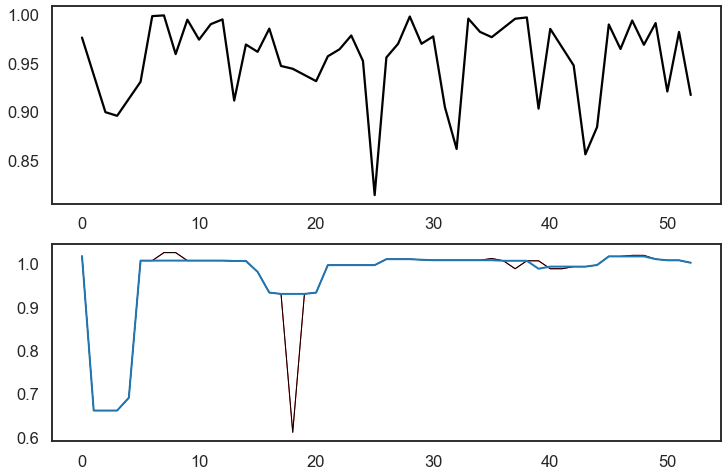

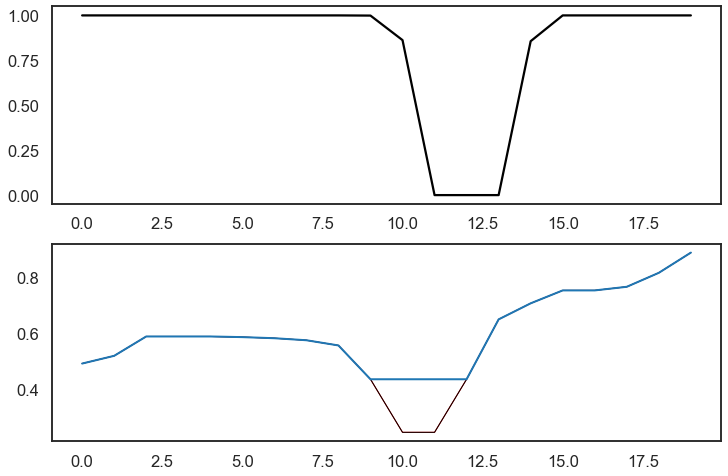

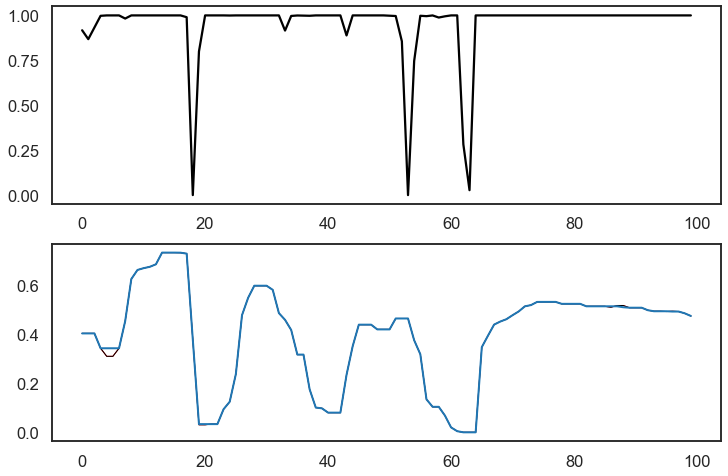

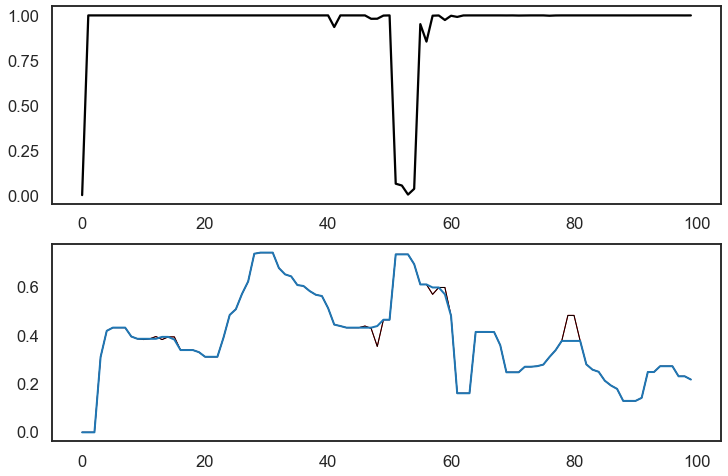

In [109]:
a = 188075
b = 188128
coord = 'y'
if coord == 'x':
    orig = labels[:, nl]
    orig_filt = x
else:
    orig = labels[:, n_labels+nl]
    orig_filt = y
mean2 = signal.medfilt(orig_filt, kernel_size=windowlength)
fig = quickplot(ps[:, nl], orig, orig_filt, mean2, (a-1000, b-1000))
# fig = quickplot(ps[:, nl], orig, orig_filt, mean2, (1900, 2000))
fig = quickplot(ps[:, nl], orig, orig_filt, mean2, (1200, 1220))
fig = quickplot(ps[:, nl], orig, orig_filt, mean2, (19900, 20000))
fig = quickplot(ps[:, nl], orig, orig_filt, mean2, (0, 100))

In [103]:
def quickplot(ps, label, x, mean, slc):
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.plot(ps[slice(*slc)], color='k')
    # plt.subplot(312)
    # plt.plot(ci[slice(*slc), 0])
    # plt.plot(ci[slice(*slc), 1])
    plt.subplot(212)
    plt.plot(label[slice(*slc)], linewidth=1, color='r')
    plt.plot(x[slice(*slc)], linewidth=1, color='k')
    plt.plot(mean[slice(*slc)], linewidth=2)
    plt.show()
    return fig